In [4]:
from pycausal import *
from pycausal.inference import meta_objective, binary_causal_inference_with_interventions, ProposalSCM
from pycausal.models import MDN, GMM

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import numpy as np

import torch

### This notebook is the recreation of the experiments and algorithms described by the paper:
(A Meta-Transfer Objective for Learning to Disentangle Causal Mechanisms) https://openreview.net/pdf?id=ryxWIgBFPS

## Defining the base model.

In [5]:
### (X^3 + X - X^2) * sin(X) 
base = SCM("Observational Source Model")
X = Variable("X",stats.uniform(-2,5))

y2 = sin(X) * X * (-2)

Ny = HiddenVariable("Ny",stats.norm(0,0.5)) 

Y = y2 + Ny << "Y"

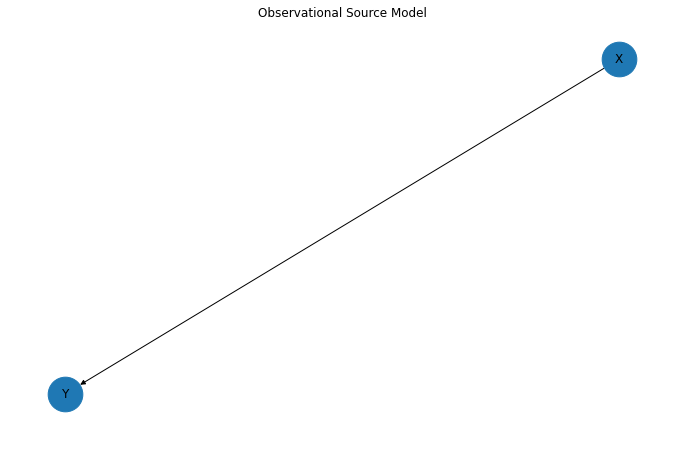

In [6]:
base.draw()

## Defining the interventions (covariance shift)

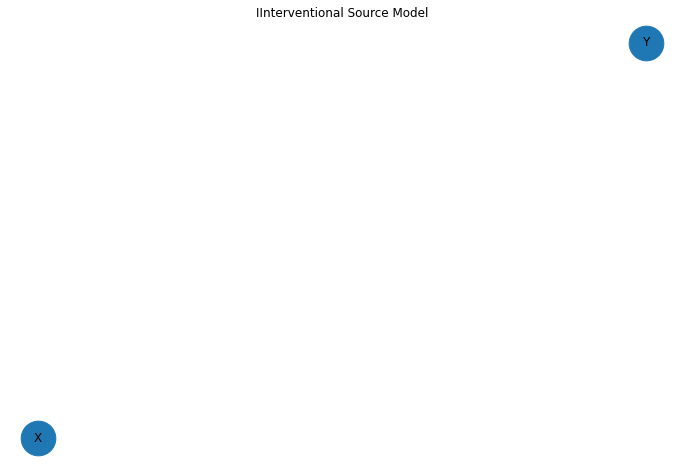

In [18]:
interv = SCM("Interventional Source Model")
iX = HiddenVariable("iX", stats.uniform(-2,5))
P = placeholder("P")

X = P + iX << "X"

y2 = sin(X) * X*(-2)

Ny = HiddenVariable("Ny",stats.norm(0,0.5))

Y = y2 + Ny << "Y"

Perturbation = HiddenVariable("Perturbation", stats.uniform(1,2))
transfer = interv.intervene({P: Perturbation})

transfer.draw()

## Samples 

In [8]:
updates=100
steps=15
episodes=100
lr = 1e-3
metalr = 1e-1
finetune=80

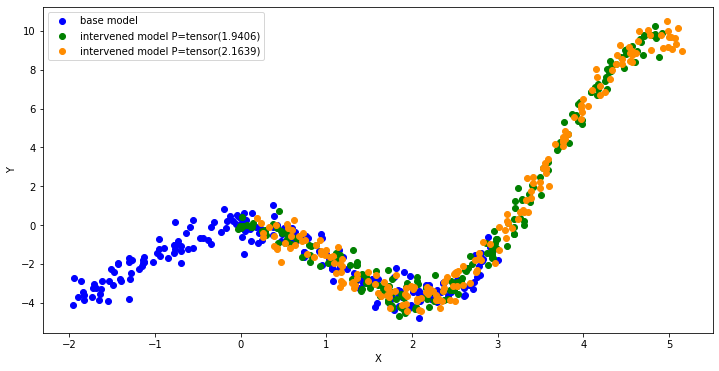

In [9]:
samples = {}
samples[base] =  base.sample(200)
samples[transfer] =  [transfer.sample(200),transfer.sample(200)]

plt.figure(figsize=(12,6))
plt.scatter( samples[base][base.nodes["X"]], samples[base][base.nodes["Y"]], label="base model", c="blue") 

p = samples[transfer][0][P][0,0]
plt.scatter( samples[transfer][0][X], samples[transfer][0][Y], 
            label="intervened model P="+ str(p),c="green")

p = samples[transfer][1][P][0,0]
plt.scatter( samples[transfer][1][X], samples[transfer][1][Y], 
            label="intervened model P="+ str(p),c="darkorange")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

2.4479710459709167
2.1937806606292725


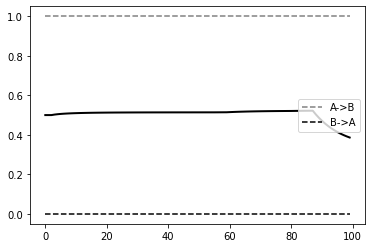

0.3865163

In [19]:
binary_causal_inference_with_interventions(
        base, transfer, "X", "Y", epochs=500, steps=15,
        episodes=100, lr=1e-2, metalr=1e-1, finetune=20)

## An in depth look at what binary_causal_inference_with_interventions is doing

In [20]:
updates = 500
steps=15
finetune=20
episodes=100
lr=1e-2
metalr=1e-1

## Learning L ( X -> Y )

In [21]:
modelxx = GMM(10)
lossxx = modelxx.fit(base, "X", loss_type="EM", entropy_reg=True, epochs=updates)
modelxy = MDN([1,36],10)
lossxy = modelxy.fit(base, "X", "Y", loss_type="EM", reg=True, epoch=updates)

## Learning L ( Y -> X )

In [ ]:
modelyy = GMM(10)
lossyy = modelyy.fit(base, "Y", loss_type="EM", entropy_reg=True, epochs=updates)
modelyx = MDN([1,36],10)
lossyx = modelyx.fit(base, "Y", "X", loss_type="EM", reg=True, epoch=updates)

In [ ]:
plt.plot(lossxy,label="log p(y|x)")
plt.plot(lossyx,label="log p(x|y)")
plt.legend()
plt.ylabel("log probability")
plt.xlabel("steps")

plt.show()

plt.plot(lossxx,label="log p(x)")
plt.plot(lossyy,label="log p(y)")
plt.legend()
plt.ylabel("log probability")
plt.xlabel("steps")

plt.show()

## learned model 

In [ ]:
xx = samples[base][base.nodes["X"]]
yy =  samples[base][base.nodes["Y"]]

xx_i = samples[transfer][0][X]
yy_i =  samples[transfer][0][Y]

xx_k = samples[transfer][1][X]
yy_k =  samples[transfer][1][Y]

predxy = modelxy.predict(xx)
predxy_i = modelxy.predict(xx_i)


plt.figure(figsize=(14,8))
plt.scatter(xx,yy, label="base",c="blue")
plt.scatter(xx_i,yy_i, label="transfer 1",c="green")
plt.scatter(xx_k,yy_k, label="transfer 2",c="darkorange")
plt.scatter(xx, predxy, label="predicted (base)", c="cyan")
plt.scatter(xx_i, predxy_i, label="predicted (transfer 1)",c ="lightgreen")

plt.legend()
plt.show()

In [ ]:
_, g = meta_objective(transfer, "X", "Y", modelxx, modelxy, modelyy, modelyx,
                lr=lr, metalr=metalr, episodes=episodes,
                steps=steps, finetune=finetune)

In [ ]:
plt.plot(g, linewidth=2,c="black")
plt.plot(np.ones(episodes),label="X->Y",linestyle='dashed',c="grey")
plt.plot(np.zeros(episodes),label="Y->X",linestyle='dashed',c="black")
plt.legend()
plt.show()